[*********************100%%**********************]  1 of 1 completed


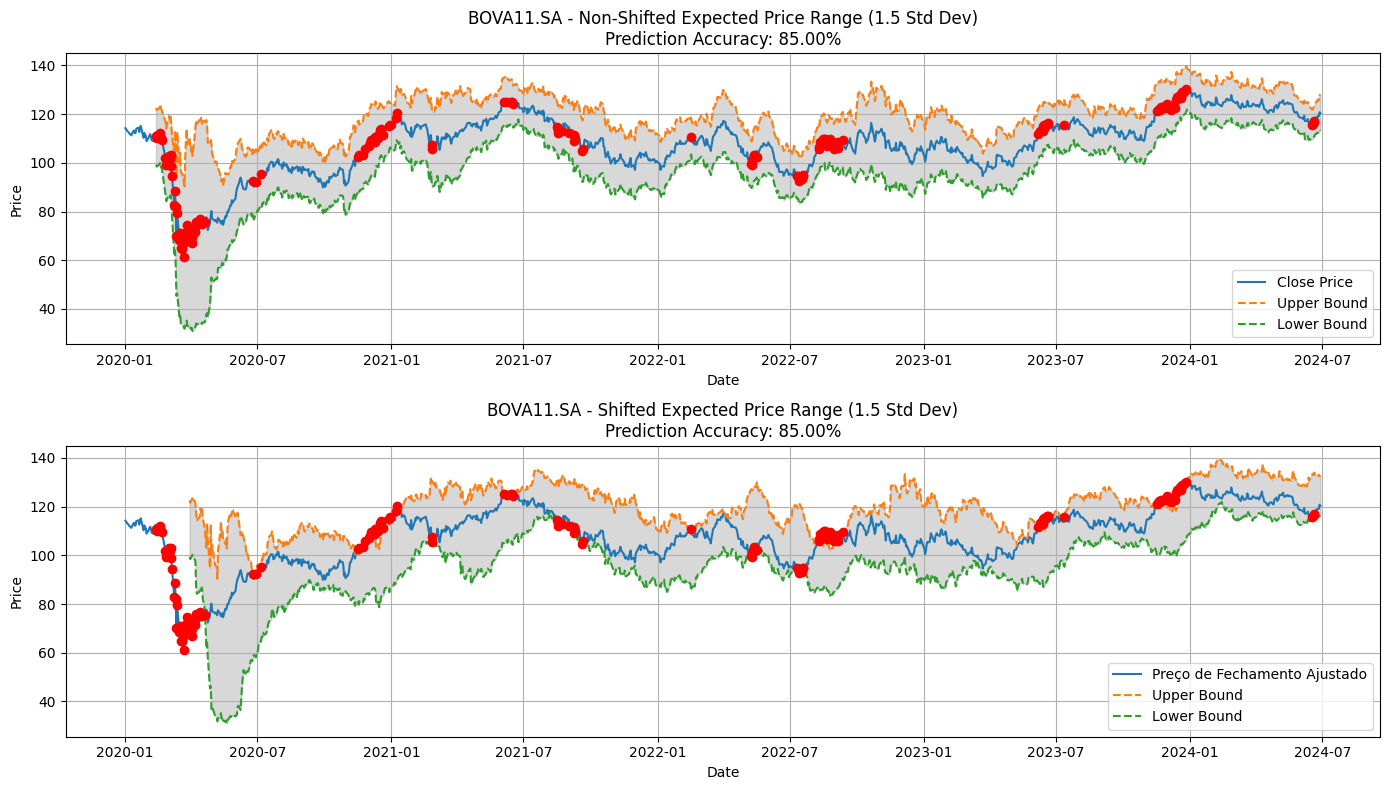

In [4]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Download preço histórico
ticker = "BOVA11.SA"
stock_data = yf.download(ticker, start="2020-01-01", end="2024-06-30")

# Calcular retorno diário
stock_data['Returns'] = stock_data['Adj Close'].pct_change()

# Calcular média móvel de 30 dias
lookback_period = 30
forward_days = 30
stock_data['Volatility'] = stock_data['Returns'].rolling(window=lookback_period).std()

# Calcular o preço esperado usando o DP
std_multiplier = 1.5
stock_data['Expected Move'] = stock_data['Close'] * stock_data['Volatility'] * np.sqrt(forward_days) * std_multiplier

# Computar as médias
stock_data['Upper Price'] = stock_data['Close'] + stock_data['Expected Move']
stock_data['Lower Price'] = stock_data['Close'] - stock_data['Expected Move']

# Avaliar o modelo
successful_predictions = 0
total_predictions = 0
unsuccessful_predictions = []
for i in range(len(stock_data) - forward_days):
    upper_price = stock_data.iloc[i]['Upper Price']
    lower_price = stock_data.iloc[i]['Lower Price']
    actual_price = stock_data.iloc[i + forward_days]['Close']
    if lower_price <= actual_price <= upper_price:
        successful_predictions += 1
    else:
        unsuccessful_predictions.append(stock_data.index[i + forward_days])
    total_predictions += 1

prediction_accuracy = successful_predictions / total_predictions

# Store the original bounds before shifting them
stock_data['Original Upper Price'] = stock_data['Upper Price']
stock_data['Original Lower Price'] = stock_data['Lower Price']

# Shift the Upper Price and Lower Price columns by the number of forward_days
stock_data['Upper Price'] = stock_data['Upper Price'].shift(forward_days)
stock_data['Lower Price'] = stock_data['Lower Price'].shift(forward_days)

# Plotting the data using Matplotlib
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 8))

# First plot for non-shifted bounds
ax1.plot(stock_data['Close'], label='Close Price')
ax1.plot(stock_data['Original Upper Price'], label='Upper Bound', linestyle='--')
ax1.plot(stock_data['Original Lower Price'], label='Lower Bound', linestyle='--')
ax1.fill_between(stock_data.index, stock_data['Original Lower Price'], stock_data['Original Upper Price'], color='gray', alpha=0.3)
for date in unsuccessful_predictions:
    ax1.plot(date, stock_data.loc[date, 'Close'], 'ro')
ax1.set_title(f'{ticker} - Non-Shifted Expected Price Range ({std_multiplier} Std Dev)\nPrediction Accuracy: {prediction_accuracy * 100:.2f}%')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# Second plot for shifted bounds
ax2.plot(stock_data['Close'], label='Preço de Fechamento Ajustado')
ax2.plot(stock_data['Upper Price'], label='Upper Bound', linestyle='--')
ax2.plot(stock_data['Lower Price'], label='Lower Bound', linestyle='--')
ax2.fill_between(stock_data.index, stock_data['Lower Price'], stock_data['Upper Price'], color='gray', alpha=0.3)
for date in unsuccessful_predictions:
    ax2.plot(date, stock_data.loc[date, 'Close'], 'ro')
ax2.set_title(f'{ticker} - Shifted Expected Price Range ({std_multiplier} Std Dev)\nPrediction Accuracy: {prediction_accuracy * 100:.2f}%')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()